# **Standard pipeline: analyzing 5K PBMC dataset from 10X genomics**

# # Import library and environment setup

In [2]:
#Only run once so not anymore
#!pip install snapatac2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 3.0 MB/s eta 0:00:0000:0100:01
  Using cached plotly-5.13.0-py2.py3-none-any.whl (15.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 25.7 MB/s eta 0:00:0000:0100:01
  Using cached igraph-0.10.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 15.6 MB/s eta 0:00:0000:0100:01
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)
  Using cached texttable-1.6.7-py2.py3-none-any.whl (10 kB)
  Using cached tenacity-8.2.1-py3-none-any.whl (24 kB)


In [1]:
import snapatac2 as snap
import scanpy as sc

In [2]:
#Download the fragment file.

# Input files
fragment_file = snap.datasets.pbmc500()
fragment_file

PosixPath('/home/imarais/.cache/snapatac2/atac_pbmc_500.tsv.gz')

In [3]:
snap.genome.hg38

# Preprocessing

In [3]:
#backed mode used
# import magic
data = snap.pp.import_data(
    fragment_file,
    genome=snap.genome.hg38,
    file="pbmc.h5ad",
    sorted_by_barcode=False,
    low_memory=False,
)
data

AnnData object with n_obs x n_vars = 816 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

To identify usable/high-quality cells, we can plot TSS enrichment against number of unique fragments for each cell

In [4]:
#if it doesnt run then its fine, this function has a current issue
snap.pl.tsse(data, interactive=False)

ValueError: Cannot __getitem__ on Series of dtype: 'UInt64' with argument: 'shape: (816,)
Series: 'n_fragment' [bool]
[
	false
	true
	true
	true
	true
	true
	false
	false
	true
	true
	true
	true
	...
	true
	true
	true
	true
	false
	true
	false
	true
	true
	true
	false
	true
	false
]' of type: '<class 'polars.internals.series.series.Series'>'.

According to the above plot, we decided to choose minimum TSS enrichment of 10 and minimum number of fragments of 5000 to filter the cells.

In [4]:
snap.pp.filter_cells(data, min_counts=5000, min_tsse=10, max_counts=50000)
data

AnnData object with n_obs x n_vars = 474 x 0 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

We next create a cell by bin matrix containing insertion counts across genome-wide 500-bp bins

In [5]:
snap.pp.add_tile_matrix(data)

In [6]:
data

AnnData object with n_obs x n_vars = 474 x 6176550 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

The default feature selection algorithm selects variable features. You can pass filter list to the function such as blacklist or whitelist.

In [6]:
snap.pp.select_features(data)

## Doublet removal

In [7]:
#apply a customized scrublet algorithm to identify potential doublets

snap.pp.scrublet(data)

2023-02-24 15:26:21 - INFO - Simulating doublets...
2023-02-24 15:26:21 - INFO - Spectral embedding ...
2023-02-24 15:26:22 - INFO - Calculating doublet scores...


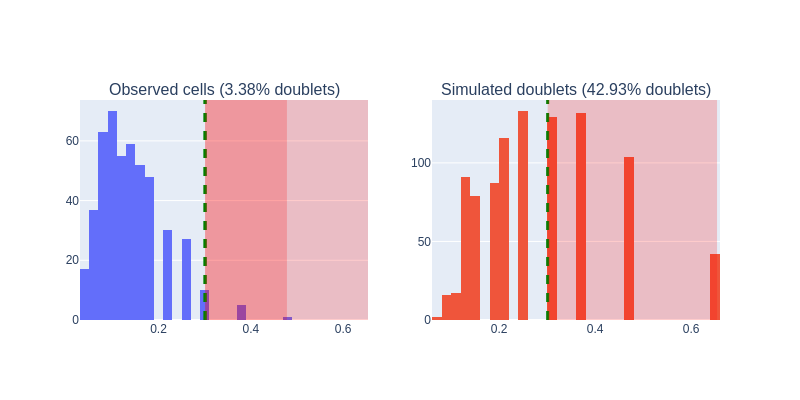

In [8]:
snap.pp.call_doublets(data)
snap.pl.scrublet(data, interactive=False)

Note the .subset() method is available only in backed mode. To subset an in-memory AnnData object, use: data = data[~data.obs["is_doublet"], :] instead.

In [9]:
data.subset(~data.obs["is_doublet"])
data

AnnData object with n_obs x n_vars = 458 x 6176550 backed at 'pbmc.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet'
    var: 'selected'
    uns: 'reference_sequences', 'scrublet_threshold', 'scrublet_sim_doublet_score'
    obsm: 'insertion'

# Dimension reduction

In [10]:
#we first compute the pairwise read-depth normalized jaccard similarity then use the spectral embedding to perform the dimension reduction.

snap.tl.spectral(data)

2023-02-24 15:27:25 - INFO - Compute similarity matrix
2023-02-24 15:27:25 - INFO - Normalization
2023-02-24 15:27:25 - INFO - Perform decomposition


We then plot the top eigenvalues corresponding to the first n eigenvectors/components. Using the elbow method, we pick the first 10 components in subsequent analysis. Note that selecting approporiate number of components is critical for getting best clustering accuracy.

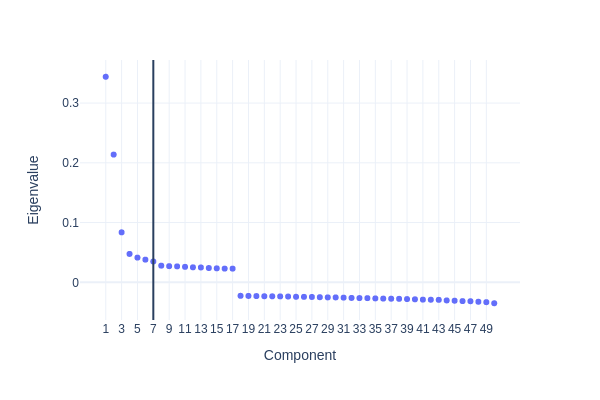

In [11]:
snap.pl.spectral_eigenvalues(data, interactive=False)

We then use UMAP to embed the cells to 2-dimension space for visualization purpose. 

In [12]:
snap.tl.umap(data, use_dims=17)
#17 based on previous graph

# Clustering analysis

In [13]:
#build a k-nearest neighbour graph using snap.pp.knn, 
#and then use the Leiden community detection algorithm to identify densely-connected subgraphs/clusters in the graph.

snap.pp.knn(data, use_dims=17)
snap.tl.leiden(data)

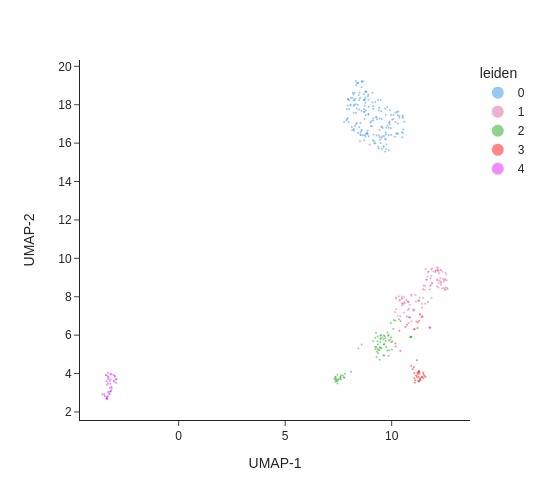

In [14]:
snap.pl.umap(data, color="leiden", interactive=False)

# Cell cluster annotation

## Create the cell by gene activity matrix

In [15]:
#annotate the clusters and assign them to known cell types
# need to compute the gene activities first for each cell using the pp.make_gene_matrix function
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38)
gene_matrix

AnnData object with n_obs × n_vars = 458 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'

In [16]:
gene_matrix.var

""
ENSG00000229986
PTPN23
AFAP1
SRP54
ENSG00000274024
...
SH2D1A
HCP5
ENSG00000266521
ZMYND12


## Imputation

We first perform gene filtering, data normalization, data transformation, and then call the sc.external.pp.magic function to complete the imputation.

In [17]:
#import scanpy as sc

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



In [21]:
#Dont run again
#!pip install python-magic

In [18]:
import magic

sc.external.pp.magic(gene_matrix, solver="approximate")

/home/imarais/.local/lib/python3.10/site-packages/magic/utils.py:145: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [19]:
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



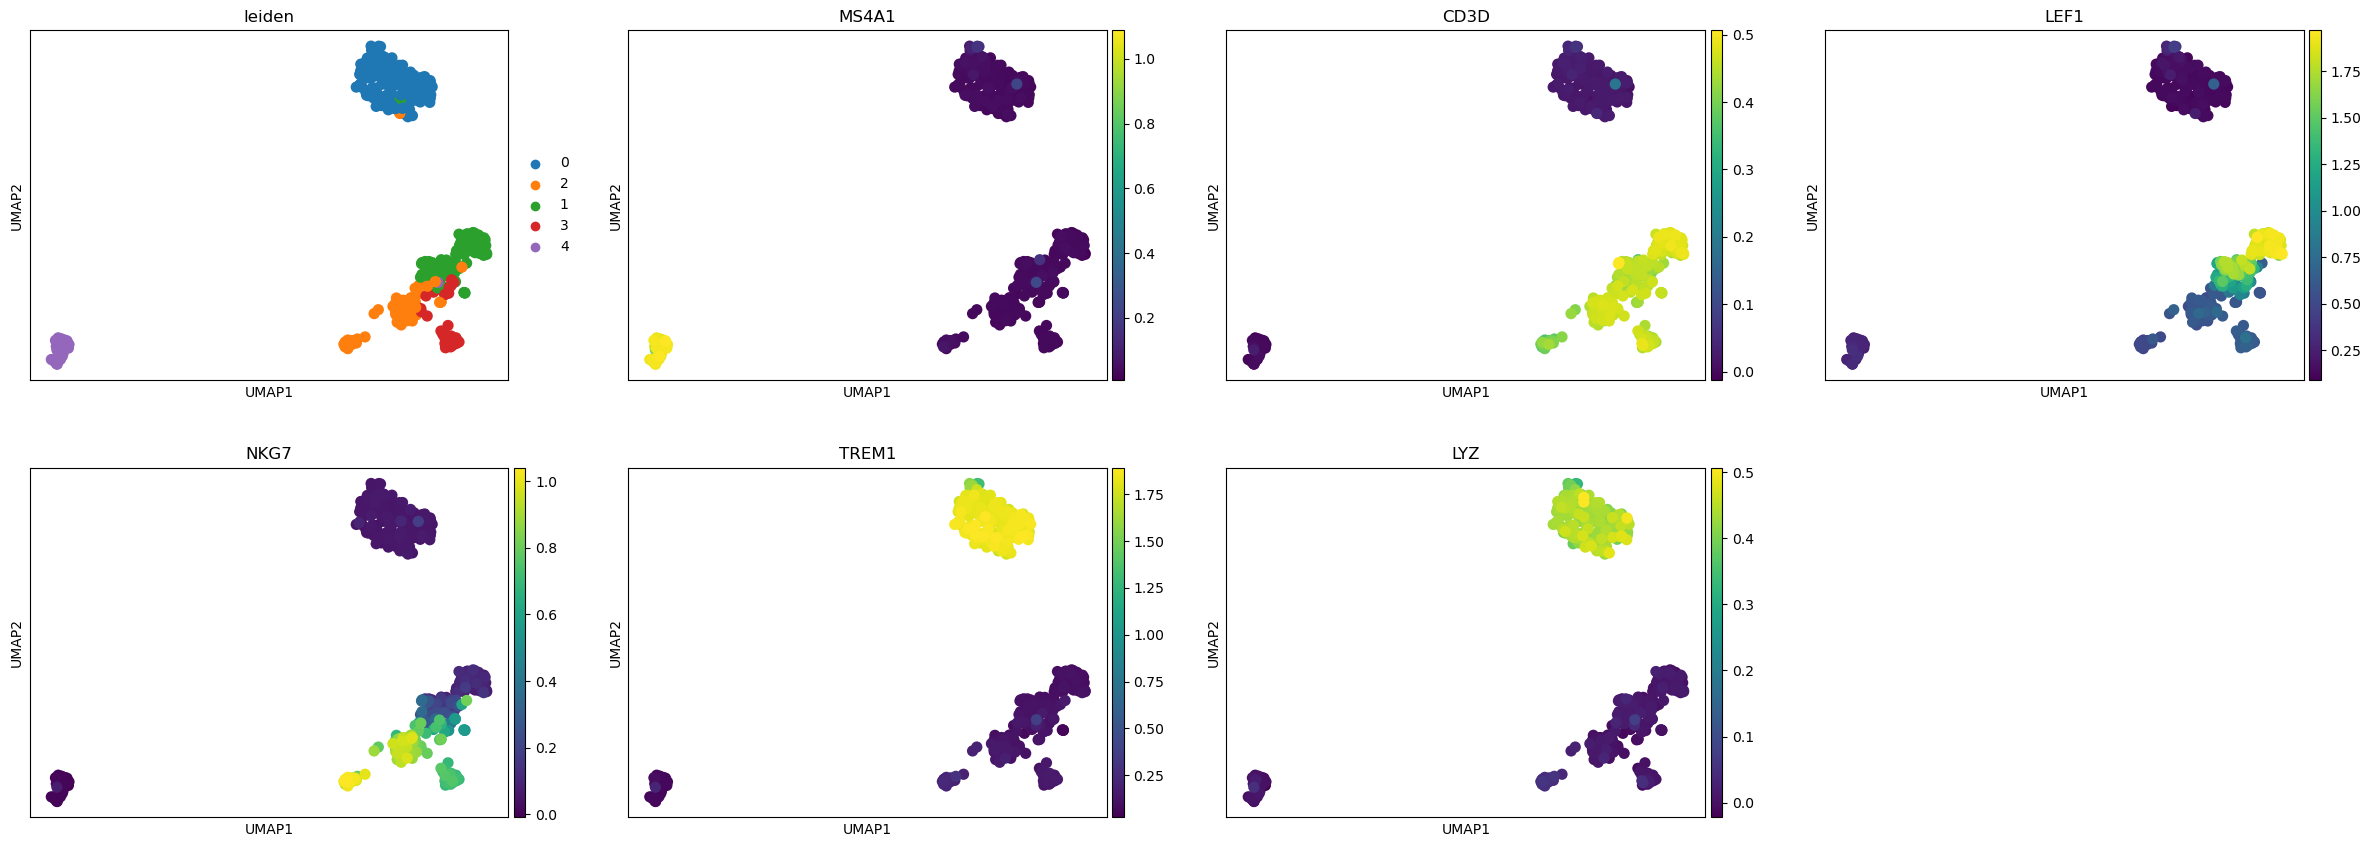

In [20]:
#visualize the gene activity of a few marker genes.
#Removed: 'PPBP'
marker_genes = ['MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes)
#sc.pl.violin(gene_matrix, marker_genes, use_raw=False, groupby='leiden')

2023-02-24 15:27:48 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-02-24 15:27:48 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-02-24 15:27:48 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-02-24 15:27:48 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-02-24 15:27:48 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

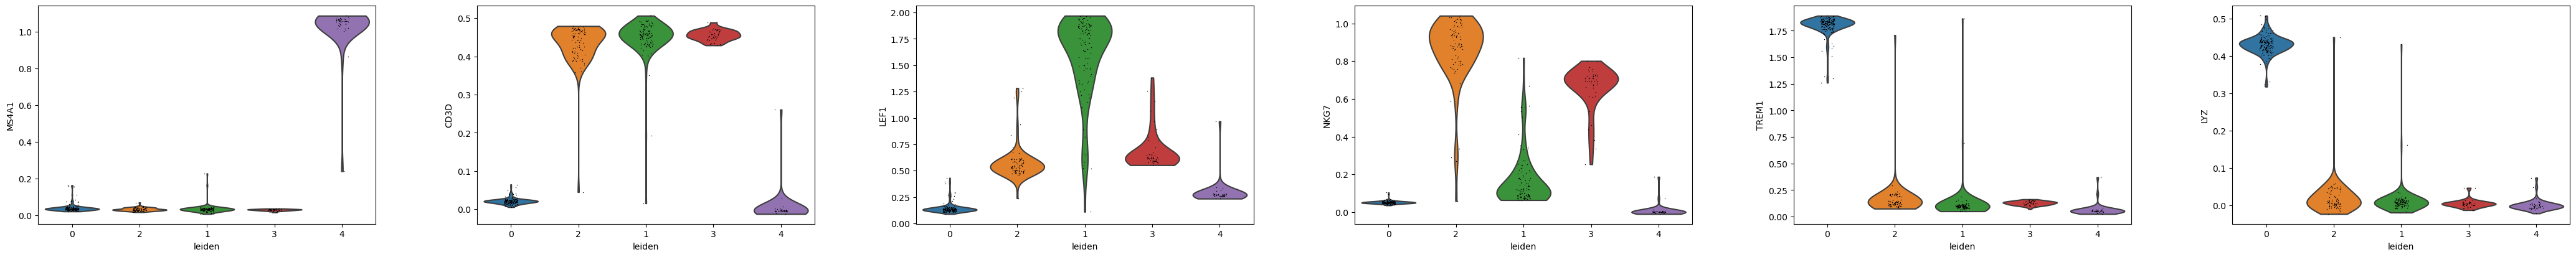

In [21]:
sc.pl.violin(gene_matrix, marker_genes, use_raw=False, groupby='leiden')

# Peak calling at the cluster-level

In [22]:
#Using snap.tl.call_peaks, we can easily identify open chromatin regions in different cell populations stratified by provided group information.
snap.tl.call_peaks(data, groupby="leiden")

2023-02-24 15:27:50 - INFO - Exporting data...
2023-02-24 15:29:39 - INFO - Calling peaks for 5 groups ...
2023-02-24 15:31:55 - INFO - Merging peaks...


In [23]:
data.uns['peaks'].head()

Peaks,0,1,2,4,3
str,bool,bool,bool,bool,bool
"""chr1:9998-1049...",false,true,false,false,true
"""chr1:191588-19...",false,false,true,false,false
"""chr1:267750-26...",true,false,false,false,false
"""chr1:629700-63...",false,true,false,false,false
"""chr1:633775-63...",false,false,false,true,true


Now, with the peak list, we can create a cell by peak matrix by snap.pp.make_peak_matrix.

In [24]:
peak_mat = snap.pp.make_peak_matrix(data, file="peak_matrix.h5ad")
peak_mat

AnnData object with n_obs x n_vars = 458 x 165179 backed at 'peak_matrix.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'

# Close AnnData objects

In [25]:
# it is important to close every backed AnnData object before shutdown the Python process to avoid HDF5 file corruptions!
peak_mat.close()
data.close()
data

Closed AnnData object

In [26]:
#remember to save any in-memory AnnData objects
gene_matrix.write("gene_matrix.h5ad")

#Now it is safe to close and shutdown the notebook! Next time you can load the results using data = snap.read("pbmc.h5ad").